In [117]:
import pymc3 as pm3
import numpy as np
import numdifftools as ndt
import pandas as pd
from scipy.stats import norm, beta
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize
import matplotlib.pyplot as plt

About Log likelihood estimation : https://rlhick.people.wm.edu/posts/estimating-custom-mle.html

In [100]:
N = 10000
h1 = 4 + np.random.randn(N)
d1 = 5 + np.random.randn(N)

sigma = 3 + .2 * h1

d2 = 3 + 5 * h1 - 2 * d1 + 3 * h1 * d1 + sigma * np.random.randn(N)

df = pd.DataFrame({'d2': d2, 'h1' : h1, 'd1' : d1, 'h1d1': h1 * d1})
df['constant'] = 1

df.head()

,d2,h1,d1,h1d1,constant
0,66.622127,3.162932,6.460132,20.432955,1
1,62.831142,4.029876,4.026593,16.226672,1
2,45.251362,3.500621,3.413268,11.948557,1
3,84.599672,5.057157,4.481368,22.662980,1
4,59.389212,4.642833,3.312925,15.381357,1


In [89]:
def _ll_ols(y, X, beta, gamma):
    mu = X.dot(beta)
    sigma = X[:,:2].dot(gamma)
    return norm(mu,sigma).logpdf(y).sum()    


In [217]:
class MyDepNormML(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyDepNormML, self).__init__(endog, exog, **kwds)
    def nloglikeobs(self, params):
        gamma = params[-2:]
        beta = params[:-2]
        ll = _ll_ols(self.endog, self.exog, beta, gamma)
        return -ll
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        # we have one additional parameter and we need to add it for summary
        self.exog_names.append('gamm1')
        self.exog_names.append('gamm2')
        if start_params == None:
            # Reasonable starting values
            start_params = np.append(np.zeros(self.exog.shape[1]), [0.5,.5])
        return super(MyDepNormML, self).fit(start_params=start_params, 
                                  maxiter=maxiter, maxfun=maxfun, 
                                  **kwds)

In [218]:
sm_ml_manual = MyDepNormML(df.d2,df[['constant','h1', 'd1', 'h1d1']]).fit(start_params = [2, 4, -1, 5, 4, 4])
print(sm_ml_manual.summary())

Optimization terminated successfully.
         Current function value: 2.739167
         Iterations: 417
         Function evaluations: 658
                             MyDepNormML Results                              
Dep. Variable:                     d2   Log-Likelihood:                -27392.
Model:                    MyDepNormML   AIC:                         5.479e+04
Method:            Maximum Likelihood   BIC:                         5.482e+04
Date:                Tue, 07 Dec 2021                                         
Time:                        16:13:47                                         
No. Observations:               10000                                         
Df Residuals:                    9996                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [92]:
# the fitted coefficients:
sm_ols_manual.params


array([-1.03133392, -0.87559337, -1.05305212,  4.08276043,  2.54928339,
        1.03135554])

## CTH  - beta distribution

In [232]:
def _ll_beta(y, X, alpha1, beta1, alpha2, beta2, p):
    B1 = beta(alpha1, beta1).pdf(y)
    B2 = beta(alpha2, beta2).pdf(y)
    H = p * B1 + (1 - p) * B2
    return np.log(H).sum()    

class MyMixBetaML(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyMixBetaML, self).__init__(endog, exog, **kwds)
    def nloglikeobs(self, params):
        alpha1, beta1 = params[:2]
        alpha2, beta2 = params[2:4]
        p = params[4]
        ll = _ll_beta(self.endog, self.exog, alpha1, beta1, alpha2, beta2, p)
        return -ll
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        # we have one additional parameter and we need to add it for summary
        self.exog_names.remove('x1')
        self.exog_names.append('alpha1')
        self.exog_names.append('beta1')
        self.exog_names.append('alpha2')
        self.exog_names.append('beta2')
        self.exog_names.append('p')
        if start_params == None:
            # Reasonable starting values
            start_params = np.append(np.zeros(self.exog.shape[1]), [0.5])
        return super(MyMixBetaML, self).fit(start_params=start_params, 
                                  maxiter=maxiter, maxfun=maxfun, 
                                  **kwds)

In [305]:
n = 100
x = np.random.rand(n)

p = .8
alpha1, beta1 = 1.3, 10
alpha2, beta2 = 2, 1
alpha1, beta1, alpha2, beta2, p = np.array([ 0.91317788,  1.91077191, 21.52071485,  6.85876098,  0.79635204])


y1 = beta.rvs(alpha1, beta1, size=n)
y2 = beta.rvs(alpha2, beta2, size=n)
u = x < p

y = u * y1 + ~u * y2
y = y * .8

sm_ml_manual = MyMixBetaML(y,y).fit(start_params = [1, 1, 1, 1, .5])
print(sm_ml_manual.summary())


Optimization terminated successfully.
         Current function value: -0.315220
         Iterations: 492
         Function evaluations: 790
                             MyMixBetaML Results                              
Dep. Variable:                      y   Log-Likelihood:                 31.522
Model:                    MyMixBetaML   AIC:                            -61.04
Method:            Maximum Likelihood   BIC:                            -58.44
Date:                Wed, 08 Dec 2021                                         
Time:                        12:21:08                                         
No. Observations:                 100                                         
Df Residuals:                      99                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

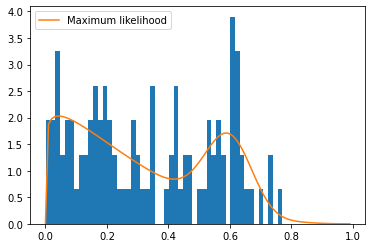

In [307]:
sm_ml_manual.params
plt.hist(y, bins = 50, density = True)


def pdf_bmix(y, alpha1, beta1, alpha2, beta2, p):
    B1 = beta(alpha1, beta1).pdf(y)
    B2 = beta(alpha2, beta2).pdf(y)
    H = p * B1 + (1 - p) * B2
    return H

x = np.arange(0, 1, .01)
plt.plot(x, pdf_bmix(x, *sm_ml_manual.params), label = 'Maximum likelihood')
# plt.plot(x, pdf_bmix(x, alpha1, beta1, alpha2, beta2, p), 'r', label = 'True distribution')
plt.legend()
plt.show()

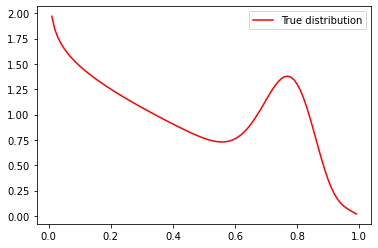

In [294]:
params = np.array([ 0.91317788,  1.91077191, 21.52071485,  6.85876098,  0.79635204])
plt.plot(x, pdf_bmix(x, *params), 'r', label = 'True distribution')
plt.legend()
plt.show()

In [298]:
pdf_bmix(x, *params)[1:].sum() * (x[1] - x[0])

0.9883018840058426